<a href="https://colab.research.google.com/github/Philliec459/Open-Source-Petrophysics/blob/main/Upscaled_BVocc_BC_Perm/SatHg_LinkedIn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:

    #!wget 'https://github.com/PDDA-OPDU/MICP-Analytics/raw/main/Upscaled_BVocc_BC_Perm/SatHg_LinkedIn.ipynb'
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install lasio
    !pip install jupyter_bokeh


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


# Final Trimmed Upscaled BVocc and Buiting-Clerke Permeability code:

Row
    [0] Column
        [0] FloatSlider(end=40, name='BV1', step=0.5, value=15)
        [1] FloatSlider(end=4, name='G1', start=0.01, step=0.01, value=0.2)
        [2] FloatSlider(end=500, name='Pd1', start=1, value=9)
        [3] FloatSlider(end=2, name='sig_G1', start=0.01, step=0.01, value=0.2)
        [4] FloatSlider(end=2, name='sig_Qd', start=0.01, step=0.01, value=0.4)
    [1] ParamFunction(function, _pane=PNG, defer_load=False)
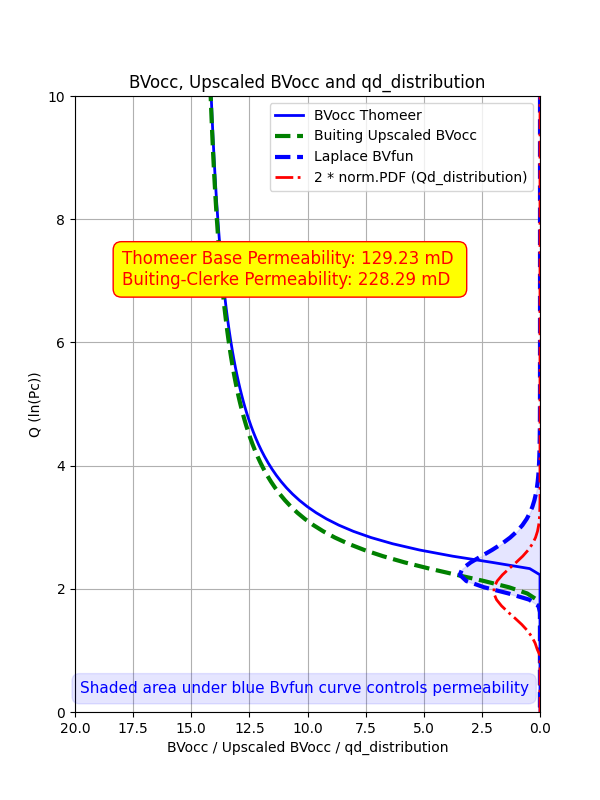

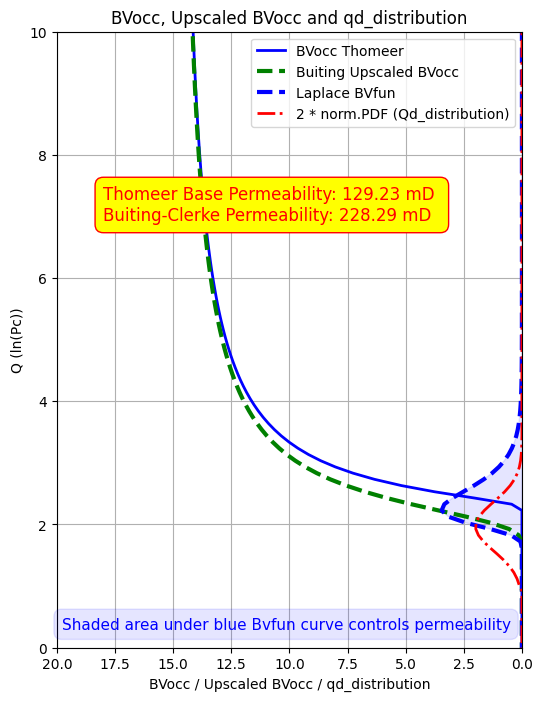

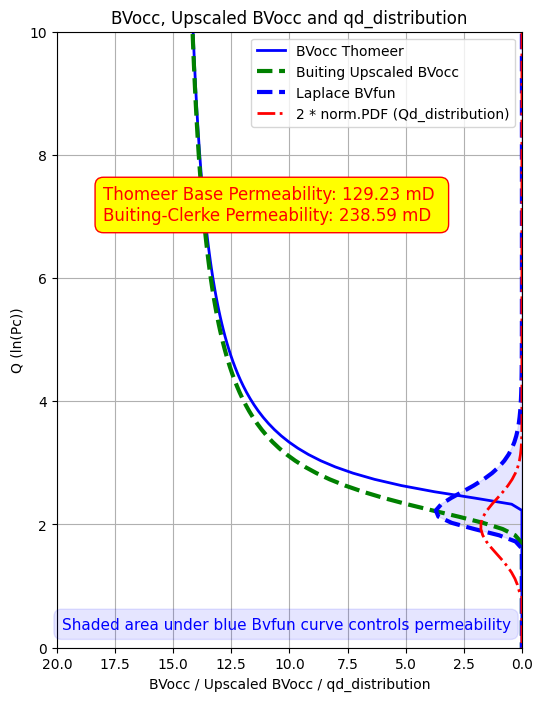

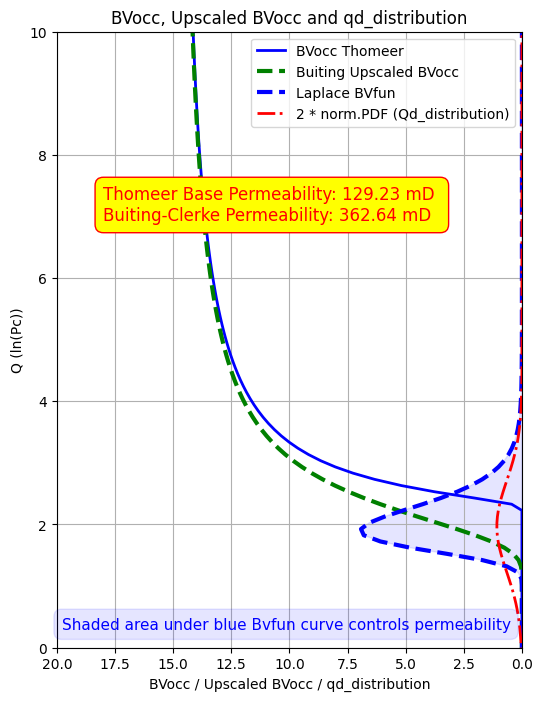

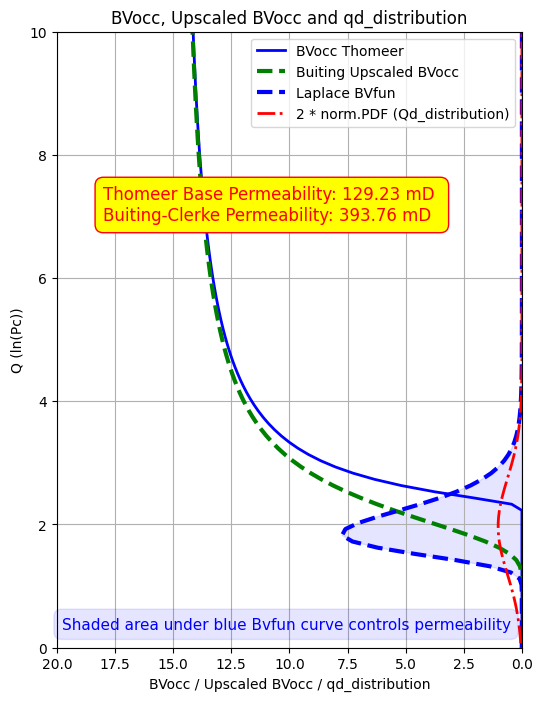

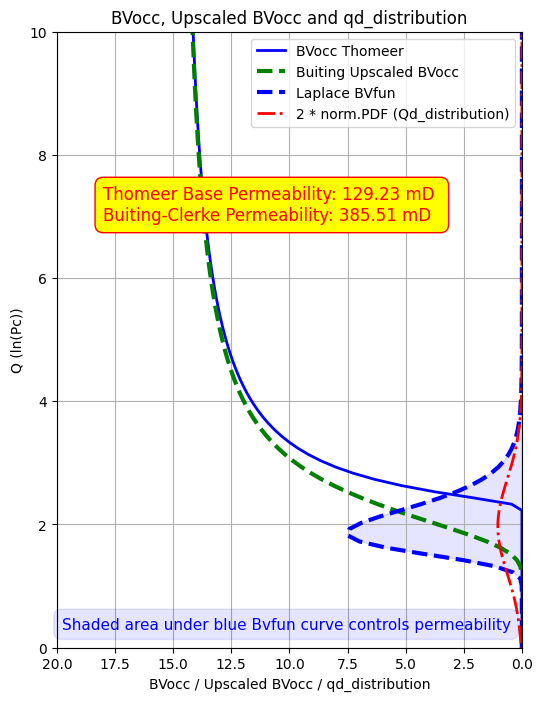

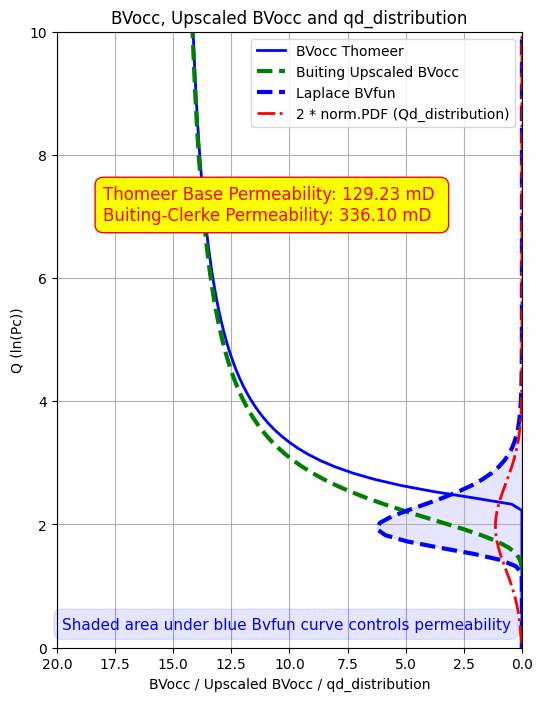

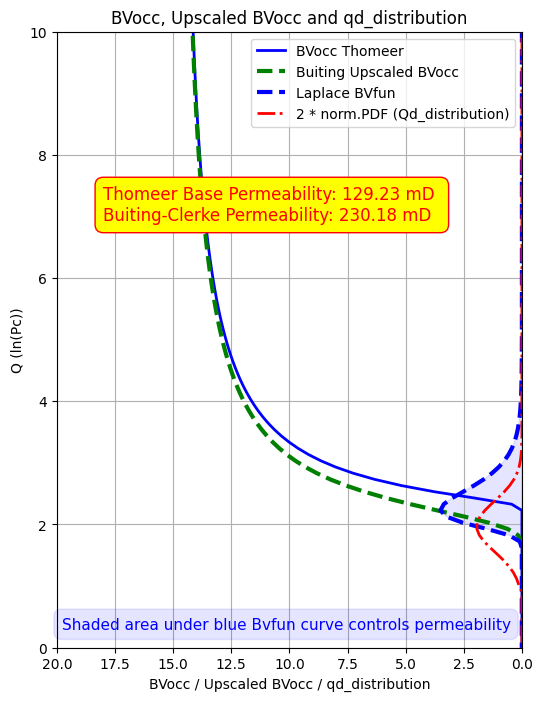

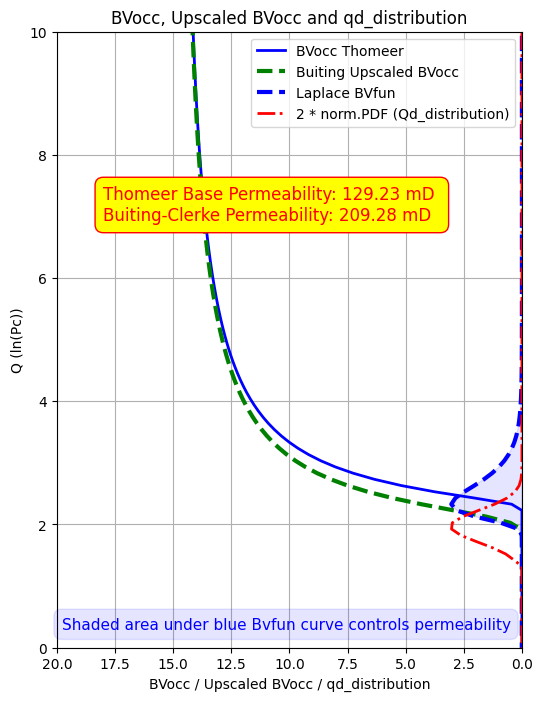

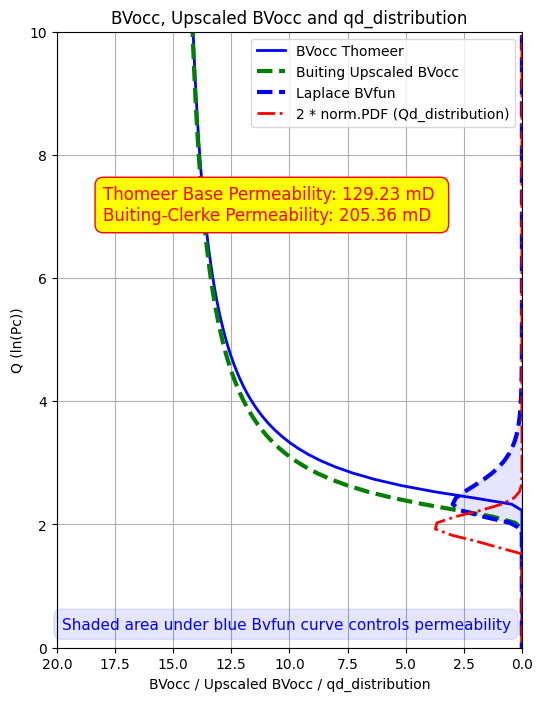

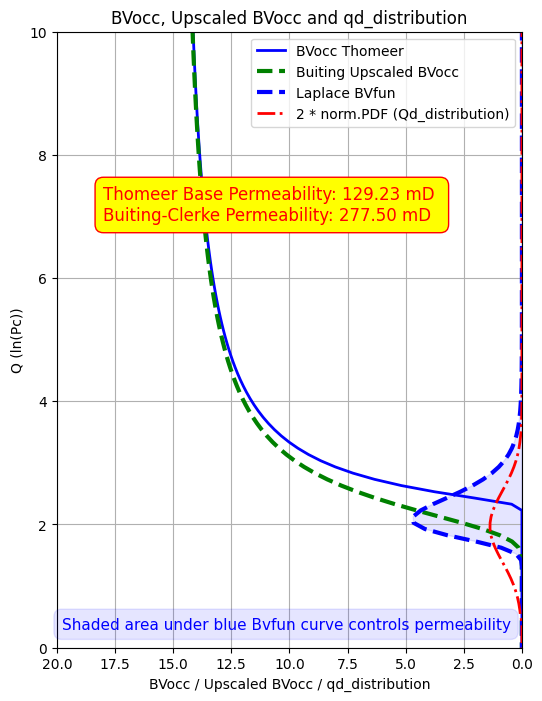

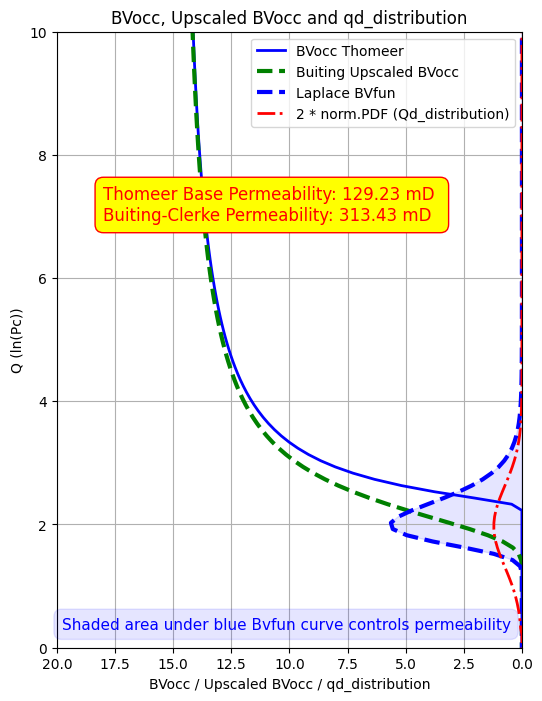

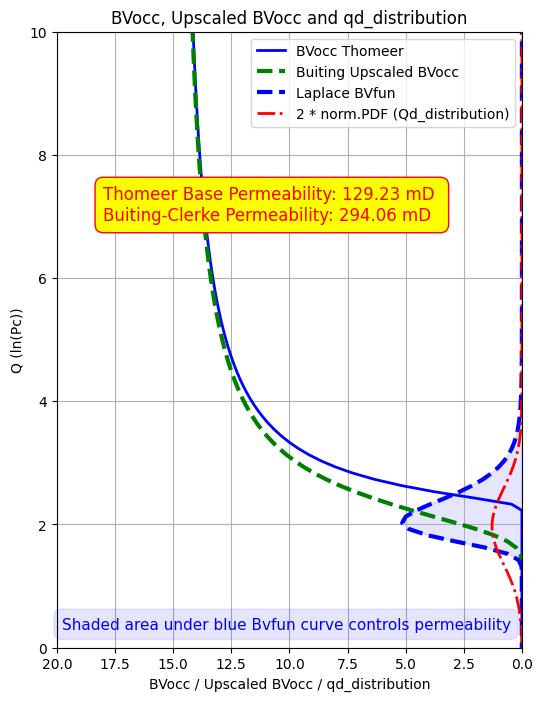

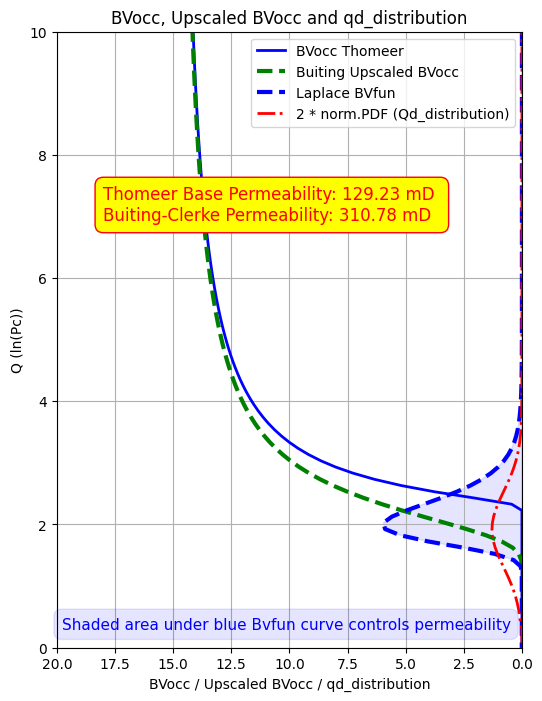

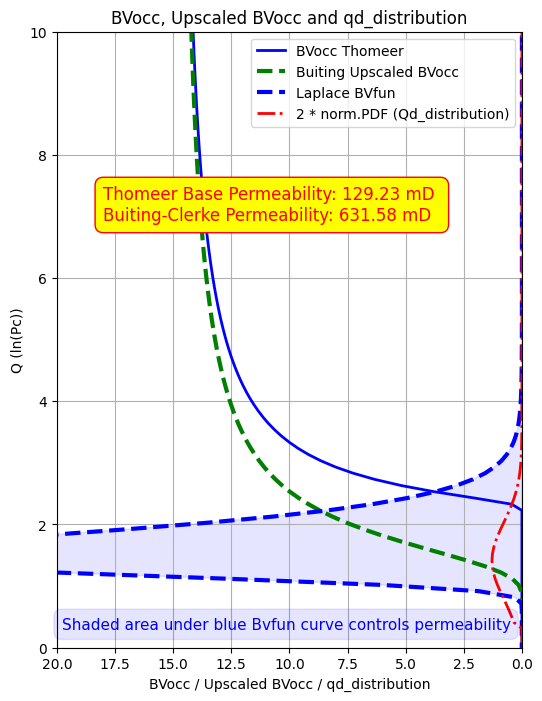

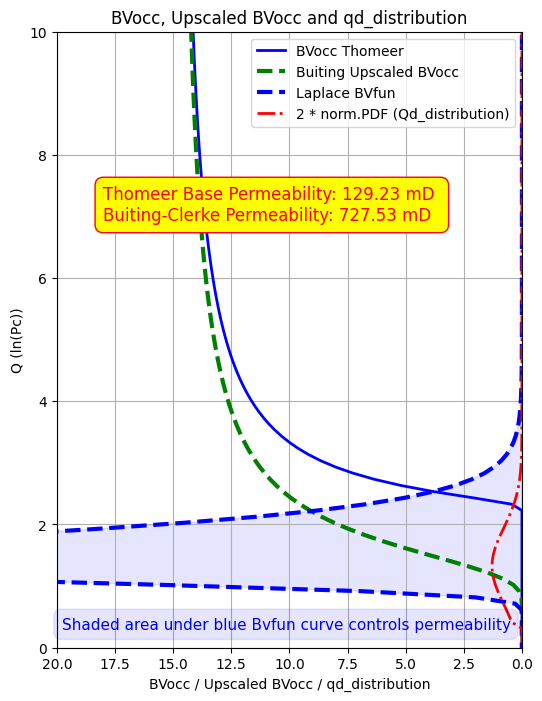

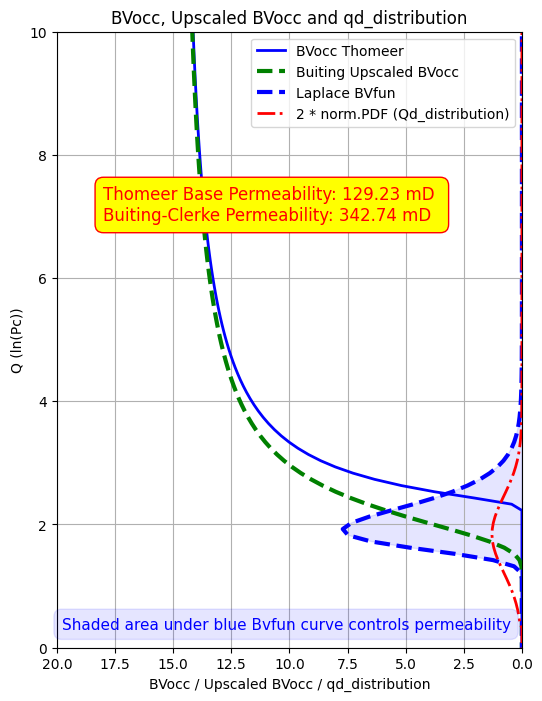

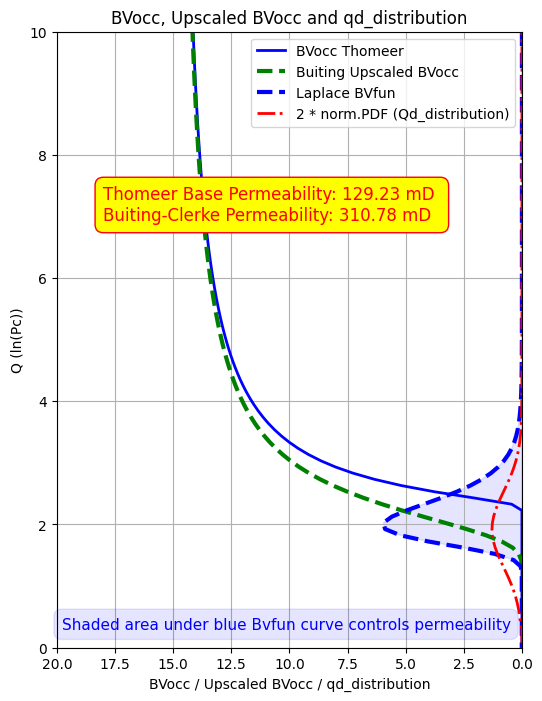

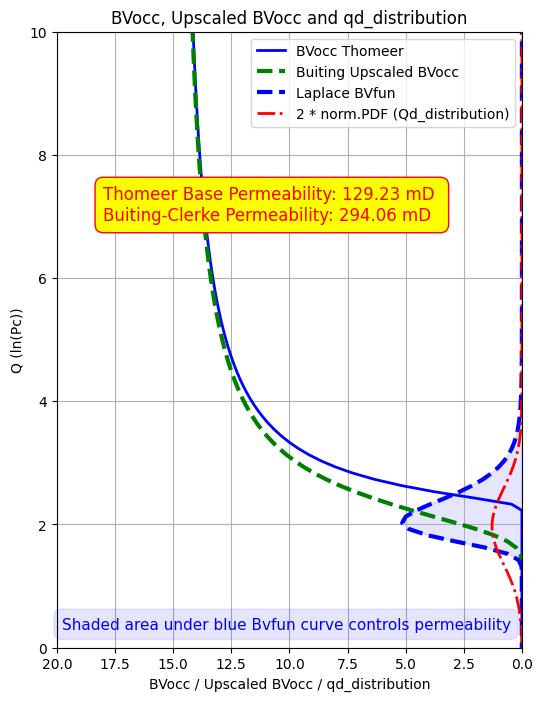

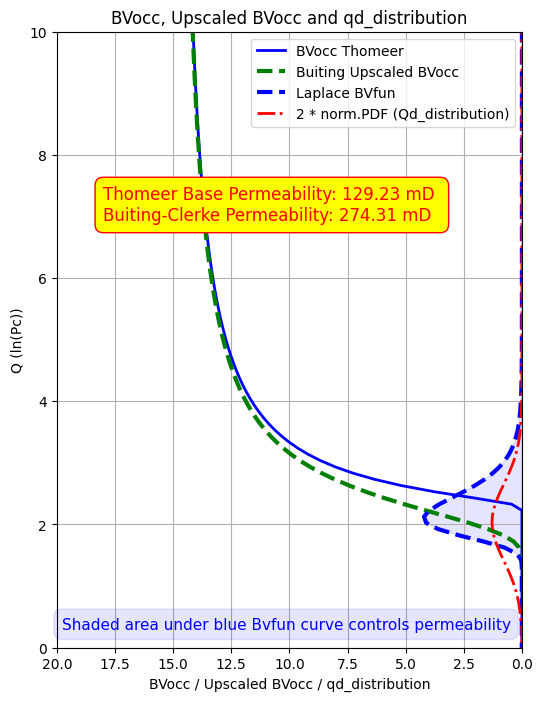

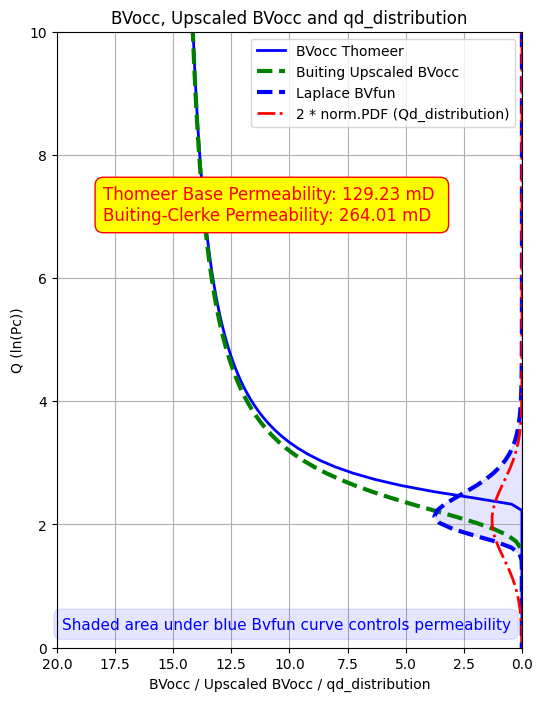

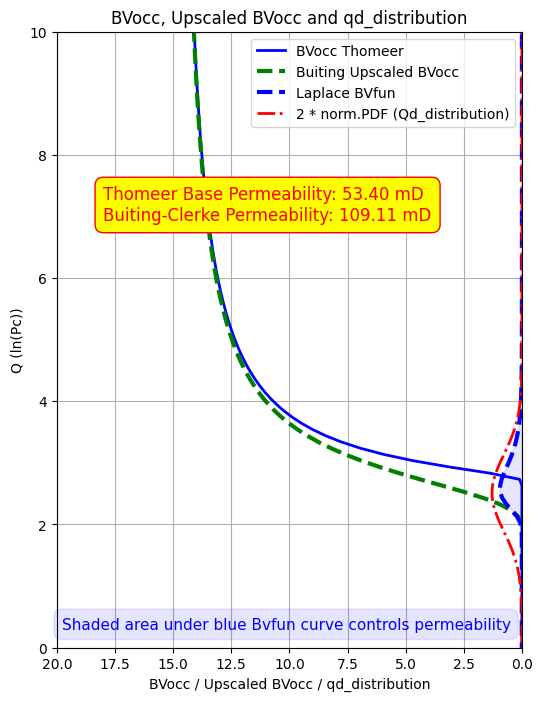

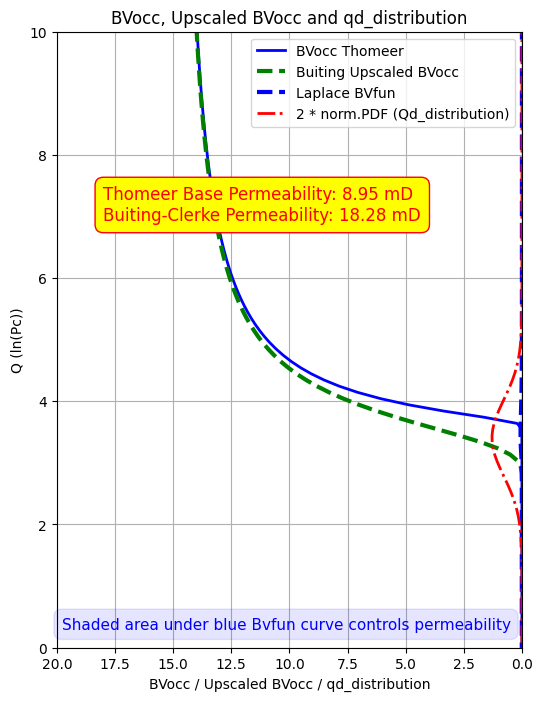

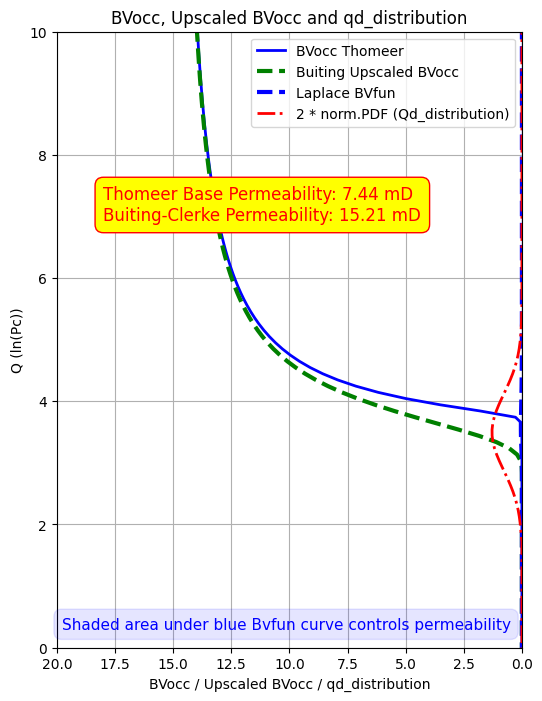

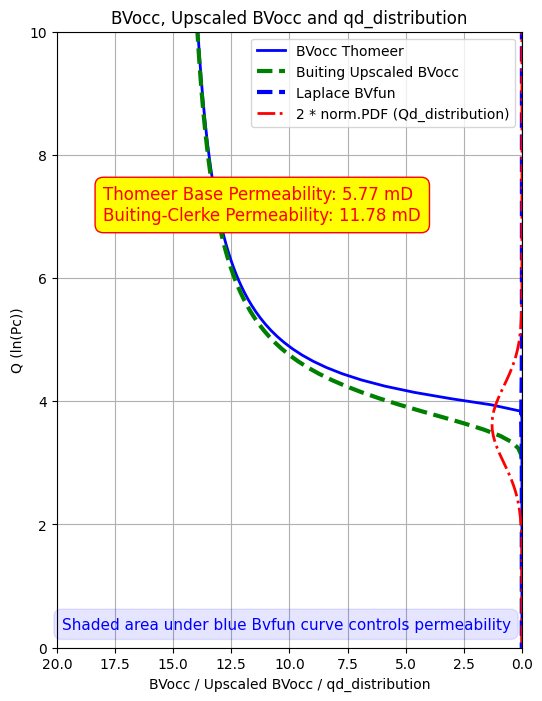

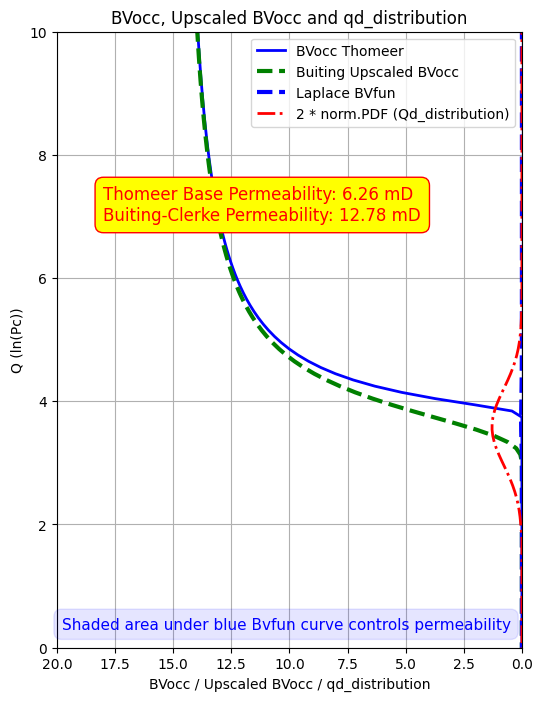

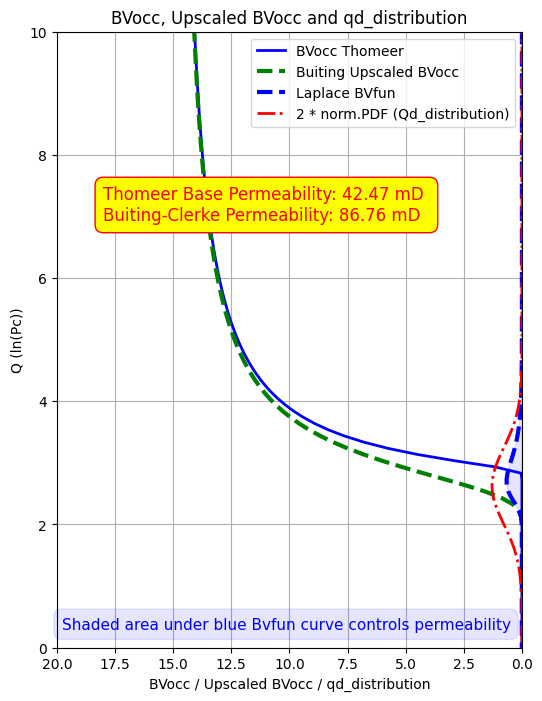

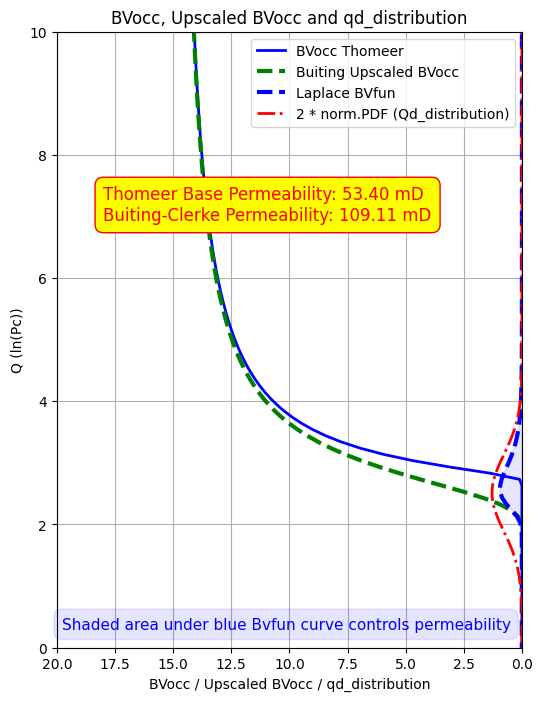

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
from scipy.stats import norm
from io import BytesIO

# Panel extension
pn.extension()





def sat_hg_norm(g_aver, sig_g, Qd_aver, sig_Qd, Q):
    """
    Calculate Hg-saturation and QdTilde based on Gaussian distributions.
    """
    delta_g = 0.5 * sig_g**2 / g_aver

    Lambda  = norm.cdf(Q, Qd_aver - delta_g, sig_Qd)
    Gauss   = norm.pdf(Q, Qd_aver - delta_g, sig_Qd)

    QdTilde = Q * (1 - Lambda) + (Qd_aver - delta_g) * Lambda - sig_Qd * sig_Qd * Gauss

    if Q > Qd_aver - 3 * sig_Qd:
        sat = np.exp(-g_aver / (Q - QdTilde))
    else:
        sat = 0

    return sat, QdTilde + 0.020



def calculate_permeability(BV1, G1, Pd1, q_values, bvocc_values, QdTilde, sig_Qd):
    """
    Calculate Buiting-Clerke permeability based on upscaled and Thomeer permeabilities.
    Ksi = ξ =   2[sigma * cos(θ)]Hg–Air ≈ 734 dyn/cm = 107 psi μm
    Thomeer_perm_paper from equation 35 in BC paper converted to mD used as base perm

    """
    D_lambda, LLd, Ksi = 1.56, 0.5, 107

    BVfun     = np.where(q_values >= (QdTilde - 3 * sig_Qd), bvocc_values * np.exp(-2 * D_lambda * q_values), 0.0)
    BVfun_sum = np.sum(BVfun)
    Constant  = (np.exp(-2 * (1 - D_lambda) * QdTilde) * (D_lambda / 4)) * LLd ** 2
    Perm_BC_intermediate = BVfun_sum * Constant * Ksi ** 2

    Thomeer_perm_paper = 10**3 * (506 * (BV1 / 100) / (Pd1 ** 2)) * np.exp(-4.43 * (G1 ** 0.5))
    Perm_BC = Thomeer_perm_paper + Perm_BC_intermediate / 3

    return Perm_BC, Thomeer_perm_paper



def plot_upscale(BV1, G1, Pd1, sig_G1, sig_Qd):
    """
    Generate the BVocc, Thomeer, and Buiting-Clerke permeability plots.
    g_aver = 2.3 * G1
    sig_g  = 2.3 * sig_G1
    Qd_aver= np.log(Pd1)
    """
    g_aver, sig_g = 2.3 * G1, 2.3 * sig_G1
    Qd_aver = np.log(Pd1)

    q_values = np.linspace(-1, 11.0, 120)
    bvocc_values, bvocc_values_thomeer, qd_distribution = [], [], []

    for Q in q_values:
        ''' Upscaled BVocc'''
        sat, QdTilde = sat_hg_norm(g_aver, sig_g, Qd_aver, sig_Qd, Q)
        bvocc_values.append(sat * BV1)

        ''' Regular Thomeer BVocc'''
        if Q > Qd_aver:
            sat_thomeer = np.exp(-g_aver / (Q - Qd_aver))
        else:
            sat_thomeer = 0
        bvocc_values_thomeer.append(sat_thomeer * BV1)

        ''' qd_distribution'''
        delta_g = 0.5 * sig_g**2 / g_aver
        Gauss   = norm.pdf(Q, Qd_aver -delta_g, sig_Qd)
        qd_distribution.append(2 * Gauss if abs(Q - Qd_aver) <= 3 * sig_Qd else 0) # 2*Gauss is so we can see it on the plot better

    ''' Buiting-Clerke Permeability '''
    Perm_BC, Thomeer_perm_paper = calculate_permeability(BV1, G1, Pd1, q_values, bvocc_values, QdTilde, sig_Qd)

    ''' Plotting of Upscaled data '''
    plt.close('all')
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.plot(bvocc_values_thomeer, q_values, label='BVocc Thomeer', color='blue', linewidth=2)
    ax.plot(bvocc_values, q_values, label='Buiting Upscaled BVocc', color='green', linestyle='--', linewidth=3)
    ax.plot(10**3 * np.array(bvocc_values) * np.exp(-2 * 1.56 * q_values), q_values, label='Laplace BVfun', color='blue', linestyle='--', linewidth=3)
    ax.fill_betweenx(q_values, 10**3 * np.array(bvocc_values) * np.exp(-2 * 1.56 * q_values), 0.01, color='blue', alpha=0.1)
    ax.plot(qd_distribution, q_values, label='2 * norm.PDF (Qd_distribution)', color='red', linestyle='-.', linewidth=2)

    # Text and labels
    text_string = f'Thomeer Base Permeability: {Thomeer_perm_paper:.2f} mD \nBuiting-Clerke Permeability: {Perm_BC:.2f} mD'
    ax.text(0.1, 0.75, text_string, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='red', facecolor='yellow'),
            color='red')

    text_string2 = f'Shaded area under blue Bvfun curve controls permeability'
    ax.text(0.01, 0.05, text_string2, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='blue', facecolor='blue',alpha=0.1),
        color='blue')

    ax.set_ylabel('Q (ln(Pc))')
    ax.set_xlabel('BVocc / Upscaled BVocc / qd_distribution')
    ax.set_xlim(20, 0)
    ax.set_ylim(0, 10)
    ax.set_title('BVocc, Upscaled BVocc and qd_distribution')
    ax.legend()
    ax.grid(True)

    return fig






''' Main Body of program featuring panel used for interactive slide bars '''
# Thomeer parameters and sliders for interactive use
BV1, G1, Pd1, sig_G1, sig_Qd = 15, 0.2, 9, 0.2, 0.4

BV1_slider     = pn.widgets.FloatSlider(name='BV1', start=0.0, end=40, step=0.5, value=BV1)
G1_slider      = pn.widgets.FloatSlider(name='G1', start=0.01, end=4, step=0.01, value=G1)
Pd1_slider     = pn.widgets.FloatSlider(name='Pd1', start=1, end=500, step=0.1, value=Pd1)
sig_G1_slider  = pn.widgets.FloatSlider(name='sig_G1', start=0.01, end=2, step=0.01, value=sig_G1)
sig_Qd_slider  = pn.widgets.FloatSlider(name='sig_Qd', start=0.01, end=2, step=0.01, value=sig_Qd)


@pn.depends(BV1_slider.param.value, G1_slider.param.value, Pd1_slider.param.value, sig_G1_slider.param.value, sig_Qd_slider.param.value)
def interactive_plot(BV1, G1, Pd1, sig_G1, sig_Qd):
    fig = plot_upscale(BV1, G1, Pd1, sig_G1, sig_Qd)
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    return pn.pane.PNG(buf, width=600)

layout = pn.Row(
    pn.Column(BV1_slider, G1_slider, Pd1_slider, sig_G1_slider, sig_Qd_slider),
    interactive_plot
)




layout.servable()
